In [1]:
from glob import glob

path = '/kaggle/input/agricultural-crops-image-classification/Agricultural-crops'

label_paths = sorted(glob(path+'/*'))

len(label_paths)

30

There are 30 class labels of crops

In [2]:
from PIL import Image
import cv2 as cv

images = [[] for _ in range(len(label_paths))]
for label in range(len(label_paths)):    
    image_paths = glob(label_paths[label]+"/*")        
    for ip in image_paths:        
        images[label].append(cv.imread(ip))        

In [3]:
import pandas as pd

sizes, labels = [],[]
for label in range(len(label_paths)):
    sizes.append(len(images[label]))
    labels.append(label)
num_by_label = pd.DataFrame({'label': labels, 'number of elements': sizes})
num_by_label

,label,number of elements
0,0,32
1,1,29
2,2,31
3,3,23
4,4,28
5,5,30
6,6,39
7,7,33
8,8,21
9,9,31


Every label has about 20-40 elements

In [4]:
shapes = pd.DataFrame([arr.shape for arr in images[0]], columns=['Rows', 'Columns', 'Channels'])
shapes.head()

,Rows,Columns,Channels
0,225,225,3
1,251,201,3
2,183,275,3
3,182,277,3
4,225,225,3


From here, we can see that images have differrent number of rows and columns. So we need to resize images to one shape.

In [5]:
H, W = 64, 128
reshaped_images = [[] for _ in range(len(images))]

for label in range(len(images)):
    for image in images[label]:
        reshaped_image = cv.resize(image, (H, W))
        reshaped_images[label].append(reshaped_image)
        
reshaped_images[0][0].shape

(128, 64, 3)

We have 829 images in total. And now every image has a shape of (64, 64, 3)

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from IPython.display import display


all_images = [img for sublist in reshaped_images for img in sublist]
labels = []


for label, images in enumerate(reshaped_images):
    labels.extend([label] * len(images))


all_images = np.array(all_images)
labels = np.array(labels)


train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, labels, test_size=0.1, stratify=labels, random_state=42
)

display(f"Train images shape: {train_images.shape}")
display(f"Test images shape: {test_images.shape}")
display(f"Train labels shape: {train_labels.shape}")
display(f"Test labels shape: {test_labels.shape}")


'Train images shape: (746, 128, 64, 3)'

'Test images shape: (83, 128, 64, 3)'

'Train labels shape: (746,)'

'Test labels shape: (83,)'

In [7]:
test_labels

array([22, 24,  4, 10, 12,  0, 27, 18, 19, 15, 14, 23,  6,  7,  7, 16,  2,
       12,  1,  3,  6, 13, 22, 18, 28, 15, 10, 20,  0, 17, 20,  5,  6, 21,
       18, 11, 16,  9, 22, 15, 29, 28, 29, 25, 29, 17, 27,  9, 28, 19, 13,
        1,  6,  8, 16, 23,  2, 13,  5, 21,  7, 12, 21, 27,  1, 24, 14, 25,
       14,  8, 26,  2,  9, 23, 19,  3,  4, 24, 26,  4, 11,  0,  5])

We divided our dataset into train and test. But we did it in such way, that test and train sets have every label in one ratio, which is - 0.1 for test and 0.9 for train.

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.X = torch.tensor(images/255, dtype=torch.float32).permute(0, 3, 1, 2)
        self.Y = torch.zeros(30*len(labels)).reshape(len(labels), 30)
        for i in range(len(labels)):
            self.Y[i][labels[i]] = 1        
        

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x, y = self.X[idx], self.Y[idx]

        return x, y


dataset = ImageDataset(train_images, train_labels)

dataset[0][0].shape, dataset[0][1].shape

(torch.Size([3, 128, 64]), torch.Size([30]))

This is my ImageDataset class. X value is a torch tensor of shape (64, 64, 3), and Y value is the tensor of shape (30), where all values are 0, except label's value which is 1.

In [9]:
from torch import nn, optim

class Net(nn.Module):
    def __init__(self, dropout_prob):
        super(Net, self).__init__()
        self.conv_block = nn.Sequential(
            nn.LazyConv2d(32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(dropout_prob), 
            
            nn.LazyConv2d(64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(dropout_prob),
                        
        )
        
        self.linear_block = nn.Sequential(
            nn.Flatten(),
            
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob), 
            
            nn.LazyLinear(30),
            nn.ReLU(),
            nn.Dropout(dropout_prob), 
        )
    
    def forward(self, x):
        y = self.conv_block(x)
        return self.linear_block(y)


I divided my model into 2 parts: convolutional block and linear block. I used ReLU not sigmoid because it is faster, and in most cases more efficient. Also, I have dropout with prob=0.5 in both blocks.

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 100/100 [15:03<00:00,  9.03s/it]


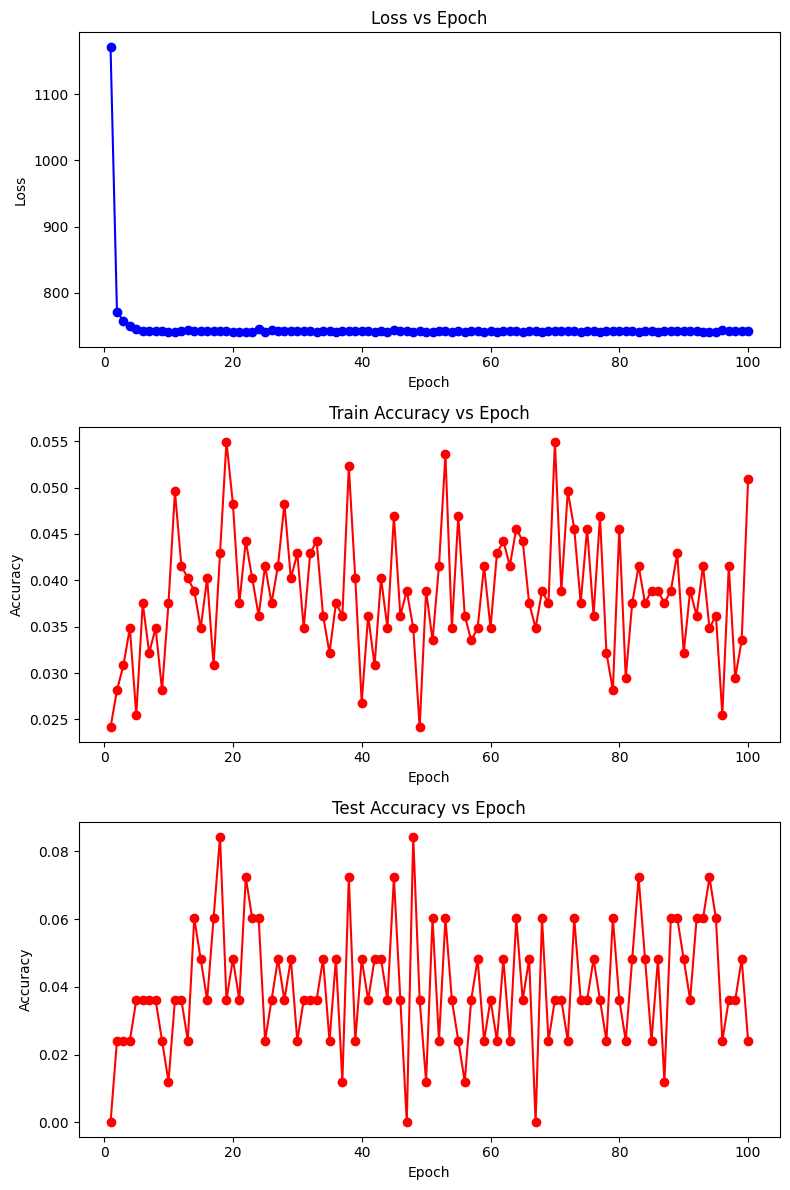

In [10]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def get_accuracy(model, test_images, test_labels):
    X = torch.tensor(test_images, dtype=torch.float32).permute(0, 3, 1, 2)
    Y = model(X)
    predicted_labels = torch.argmax(Y, dim=1).tolist()
    correct = 0
    for i in range(len(test_labels)):
        if predicted_labels[i] == test_labels[i]:
            correct += 1
    return correct / len(test_images)

def train(dataset, dropout_prob):
    model = Net(dropout_prob)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss(reduction='sum')
    epoch_count = 100
    
    dataloader = DataLoader(dataset, batch_size=32)
    
    losses, test_accuracies, train_accuracies, epochs = [], [], [], []
    
    for epoch in tqdm(range(epoch_count)):
        epoch_loss = 0
        for batch in dataloader:
            x_tensor, y_tensor = batch        
            y_pred = model(x_tensor)            
            loss = criterion(y_pred, y_tensor)            
                        
            assert not torch.isnan(loss)                                
            epoch_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()  
            
        
        losses.append(epoch_loss)
        train_accuracies.append(get_accuracy(model, train_images, train_labels))
        test_accuracies.append(get_accuracy(model, test_images, test_labels))
        epochs.append(epoch + 1)
            
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12))
    
    ax1.plot(epochs, losses, marker='o', linestyle='-', color='b')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss vs Epoch')


    ax2.plot(epochs, train_accuracies, marker='o', linestyle='-', color='r')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Train Accuracy vs Epoch')
    
    ax3.plot(epochs, test_accuracies, marker='o', linestyle='-', color='r')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy')
    ax3.set_title('Test Accuracy vs Epoch')

    plt.tight_layout()

    plt.show()


train(dataset, 0.5)

This is our results when we use dropout coefficient 0.5. We can see that results are not stable.

100%|██████████| 100/100 [14:43<00:00,  8.83s/it]


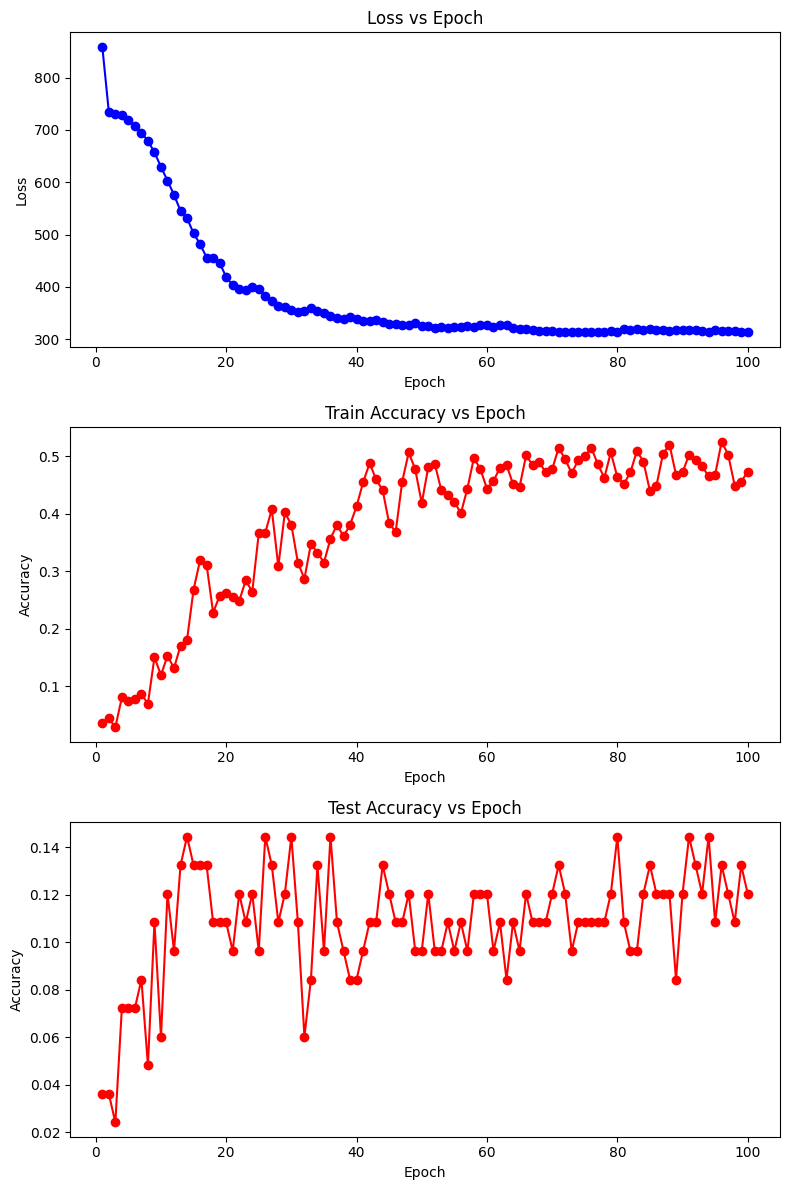

In [11]:
train(dataset, 0.0)

Here, we can see stable grow. And in general, the results become better.

As a conclusion, we can say the following:
1. In comparison to first assignment, I implemented test/train split for each class with equal ratio.
2. I changed the reshape dimension from (128, 128) to (64, 128). It increased accuracy, and this improve can be explained with that the most pictures have more width than their height
3. I implemented my dataset in such way, that y value has a dimension of (30), which filled by zeros, except label's value which is 1.
4. I divided my model into 2 parts: convolutional and linear. In convolutional part, I several times increased the number of layers and decreased the dimension. 
5. I used reLU instread of sigmoid, because its faster, and in practice, better.
6. The results without dropout layer are better and more stable. 